# Getting the data

In [1]:
library(ggplot2)
unzip('paravance-71-paravance-72_2018-06-29_1022596.zip', exdir = '/tmp/paravance_exp')

In [2]:
df = read.csv('/tmp/paravance_exp/exp/exp_Isend.csv', header=FALSE)
colnames(df) = c('op', 'msg_size', 'start', 'duration')
head(df)

op,msg_size,start,duration
MPI_Isend,765921,20.34943,7.4480e-06
MPI_Isend,765921,20.35128,7.7850e-06
MPI_Isend,765921,20.35355,7.5480e-06
MPI_Isend,765921,20.35586,7.4530e-06
MPI_Isend,765921,20.35818,8.3162e-05
MPI_Isend,765921,20.36047,7.0470e-06


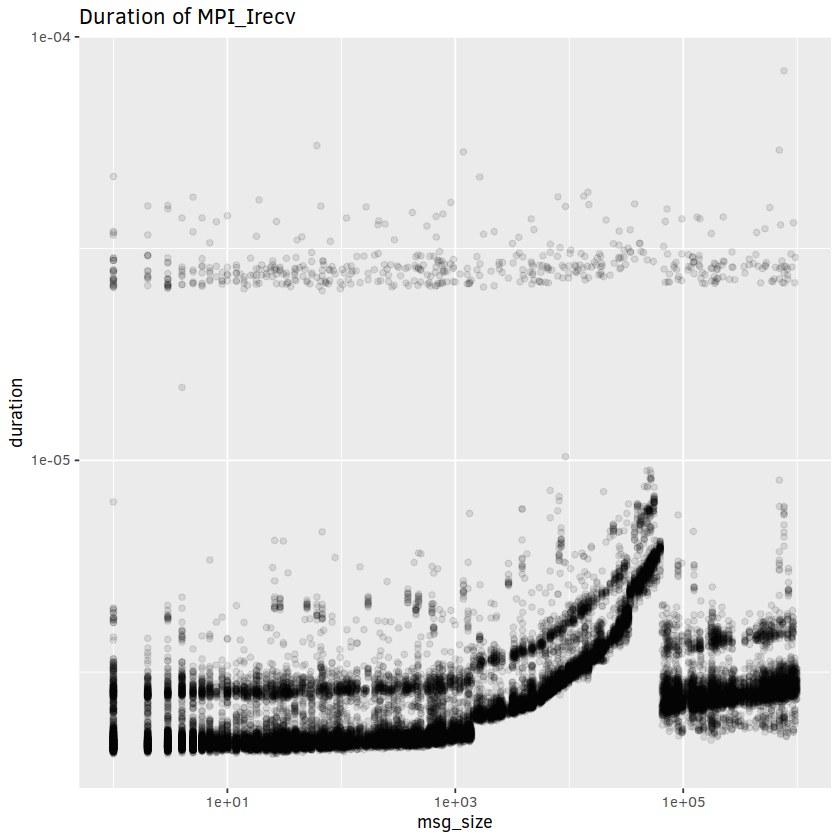

In [3]:
ggplot(df, aes(x=msg_size, y=duration)) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + ggtitle('Duration of MPI_Irecv')

Let's restrict ourselves to one zone. For instance, let's take the small messages.

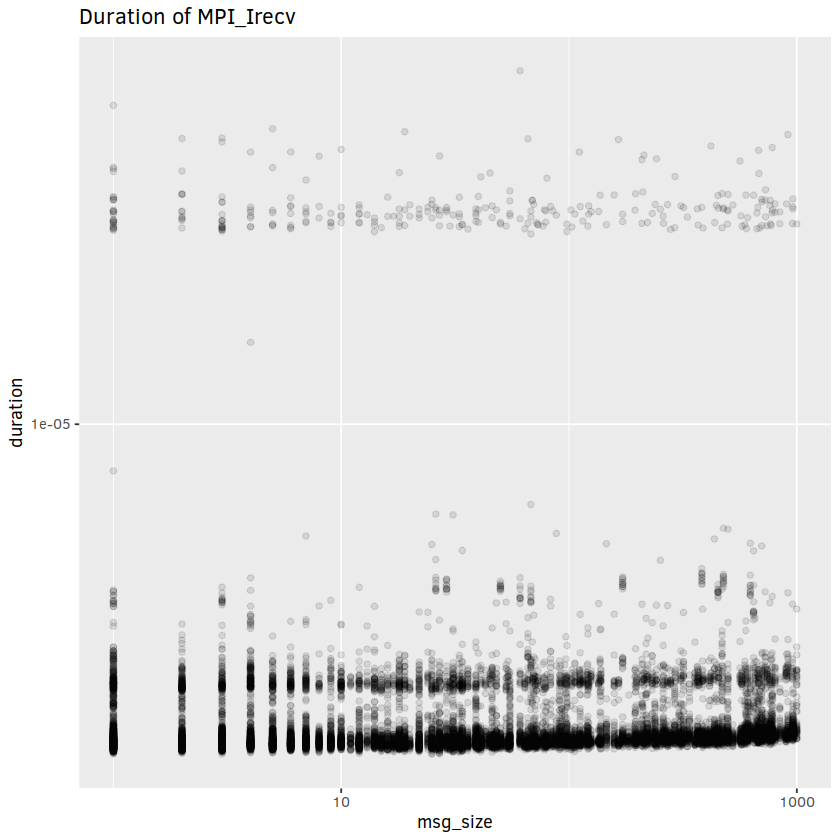

In [4]:
df = df[df$msg_size < 1000,]
ggplot(df, aes(x=msg_size, y=duration)) + geom_point(alpha=0.1) + scale_x_log10() + scale_y_log10() + ggtitle('Duration of MPI_Irecv')

# Flexmix: detecting the clusters

In [5]:
library(flexmix)
m1 = flexmix(data=df, duration~msg_size, k=3)
m1
summary(m1)
parameters(m1)
rm1 = refit(m1)
summary(rm1)

Loading required package: lattice



Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3)

Cluster sizes:
    1     2 
13815  3485 

convergence after 20 iterations


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3)

       prior  size post>0 ratio
Comp.1 0.795 13815  14124 0.978
Comp.2 0.205  3485  17300 0.201

'log Lik.' 238872.9 (df=7)
AIC: -477731.8   BIC: -477677.5 


,Comp.1,Comp.2
coef.(Intercept),2.151352e-06,4.942088e-06
coef.msg_size,1.186857e-10,4.077089e-10
sigma,5.583659e-08,7.142885e-06


Warning message in sqrt(diag(z@vcov)[indices]):
“production de NaN”

$Comp.1
              Estimate Std. Error z value Pr(>|z|)
(Intercept) 2.1514e-06         NA      NA       NA
msg_size    1.1866e-10         NA      NA       NA

$Comp.2
              Estimate Std. Error z value Pr(>|z|)
(Intercept) 4.9421e-06         NA      NA       NA
msg_size    4.0771e-10         NA      NA       NA



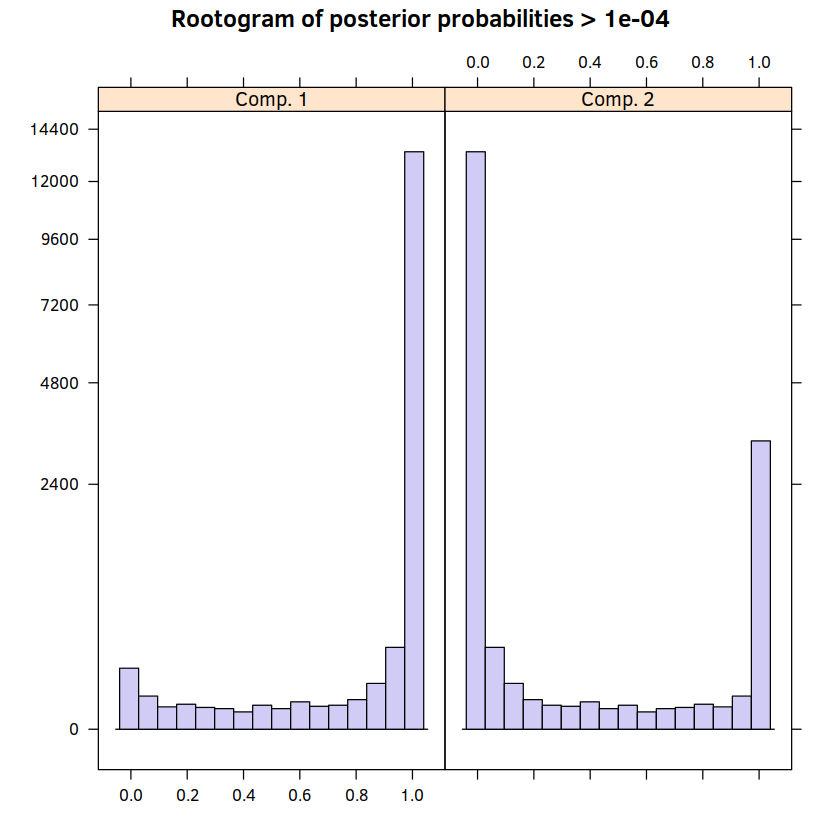

In [6]:
plot(m1)

Here, flexmix failed to find the 3 clusters. Let's try to tune the parameters.

In [7]:
m1 = flexmix(data=df, duration~msg_size, k=3, control = list(minprior = 0.01))
m1


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3, control = list(minprior = 0.01))

Cluster sizes:
    1     2     3 
  479  3384 13437 

convergence after 16 iterations

In [8]:
m1 = flexmix(data=df, duration~msg_size, k=3, control = list(minprior = 0.0001))
m1


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3, control = list(minprior = 1e-04))

Cluster sizes:
    1     2     3 
 3404 13418   478 

convergence after 12 iterations

In [9]:
m1 = flexmix(data=df, duration~msg_size, k=3, control = list(minprior = 0.01))
m1
summary(m1)
parameters(m1)
rm1 = refit(m1)
summary(rm1)


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3, control = list(minprior = 0.01))

Cluster sizes:
    1     2     3 
  479  3384 13437 

convergence after 17 iterations


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 3, control = list(minprior = 0.01))

        prior  size post>0  ratio
Comp.1 0.0283   479   7885 0.0607
Comp.2 0.2065  3384  16906 0.2002
Comp.3 0.7652 13437  13968 0.9620

'log Lik.' 247848.6 (df=11)
AIC: -495675.2   BIC: -495589.8 


,Comp.1,Comp.2,Comp.3
coef.(Intercept),1.933874e-05,2.745183e-06,2.146825e-06
coef.msg_size,-3.562708e-09,2.527723e-11,1.165885e-10
sigma,1.233664e-05,2.921796e-07,4.926544e-08


Warning message in sqrt(diag(z@vcov)[indices]):
“production de NaN”

$Comp.1
               Estimate  Std. Error z value  Pr(>|z|)    
(Intercept)  1.9339e-05  2.7220e-08  710.46 < 2.2e-16 ***
msg_size    -3.5627e-09          NA      NA        NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$Comp.2
              Estimate Std. Error z value Pr(>|z|)
(Intercept) 2.7452e-06         NA      NA       NA
msg_size    2.5267e-11         NA      NA       NA

$Comp.3
              Estimate Std. Error z value Pr(>|z|)
(Intercept) 2.1468e-06         NA      NA       NA
msg_size    1.1652e-10         NA      NA       NA



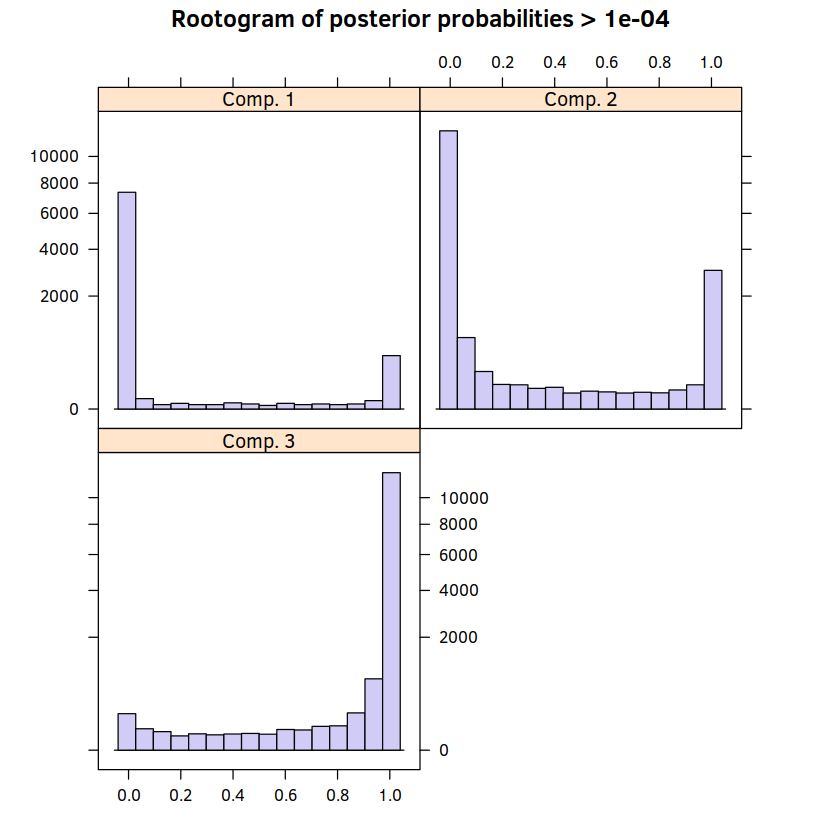

In [10]:
plot(m1)

In [11]:
library(reshape)
prediction = cbind(df[c('msg_size', 'duration')], fitted(m1))
prediction = melt(prediction, id=c('msg_size', 'duration'))

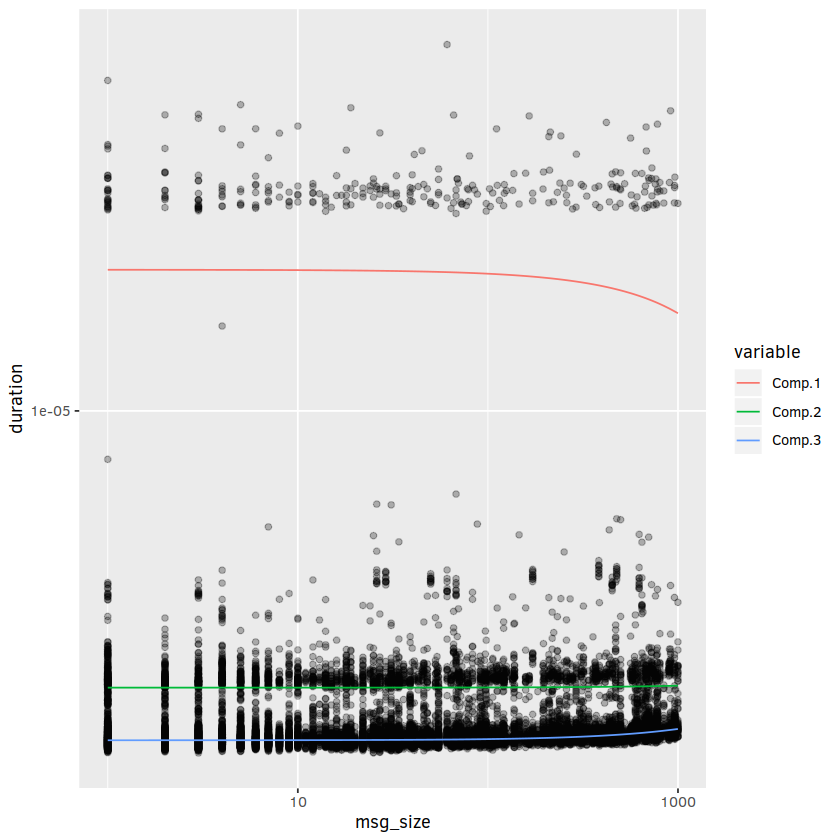

In [12]:
ggplot(prediction, aes(x=msg_size, y=duration)) + geom_point(alpha=0.1) + geom_line(aes(x=msg_size, y=value, color=variable)) + scale_x_log10() + scale_y_log10()

Ok, we finally found the right number of clusters, but this blue line is weird...

# Finding automatically the right number of clusters

In [14]:
m1 = flexmix(data=df, duration~msg_size, k=8, control = list(minprior = 0.01))
m1
summary(m1)
parameters(m1)
rm1 = refit(m1)
summary(rm1)


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 8, control = list(minprior = 0.01))

Cluster sizes:
   1    2    3    4    5    6    7    8 
 809  244 9490  914 3532 1520  287  504 

convergence after 86 iterations


Call:
flexmix(formula = duration ~ msg_size, data = df, k = 8, control = list(minprior = 0.01))

        prior size post>0  ratio
Comp.1 0.0636  809   3907 0.2071
Comp.2 0.0168  244   7916 0.0308
Comp.3 0.4965 9490  13244 0.7166
Comp.4 0.0666  914  14273 0.0640
Comp.5 0.2382 3532  13942 0.2533
Comp.6 0.0699 1520   2234 0.6804
Comp.7 0.0166  287    288 0.9965
Comp.8 0.0318  504  14259 0.0353

'log Lik.' 249877.7 (df=31)
AIC: -499693.3   BIC: -499452.8 


,Comp.1,Comp.2,Comp.3,Comp.4,Comp.5,Comp.6,Comp.7,Comp.8
coef.(Intercept),2.939769e-06,3.986025e-06,2.123391e-06,2.268253e-06,2.180602e-06,2.838557e-06,2.864391e-05,2.470581e-06
coef.msg_size,4.572296e-11,5.179105e-10,1.136268e-10,1.490055e-10,1.304243e-10,1.569218e-10,6.317544e-10,1.785885e-10
sigma,1.772780e-07,7.481296e-07,3.161429e-08,5.871229e-08,4.156489e-08,5.608942e-08,3.912259e-06,1.140001e-07


ERROR: Error in solve.default(as.matrix(fit$hessian)): routine Lapack dgesv : le système est exactement singulier : U[23,23] = 0


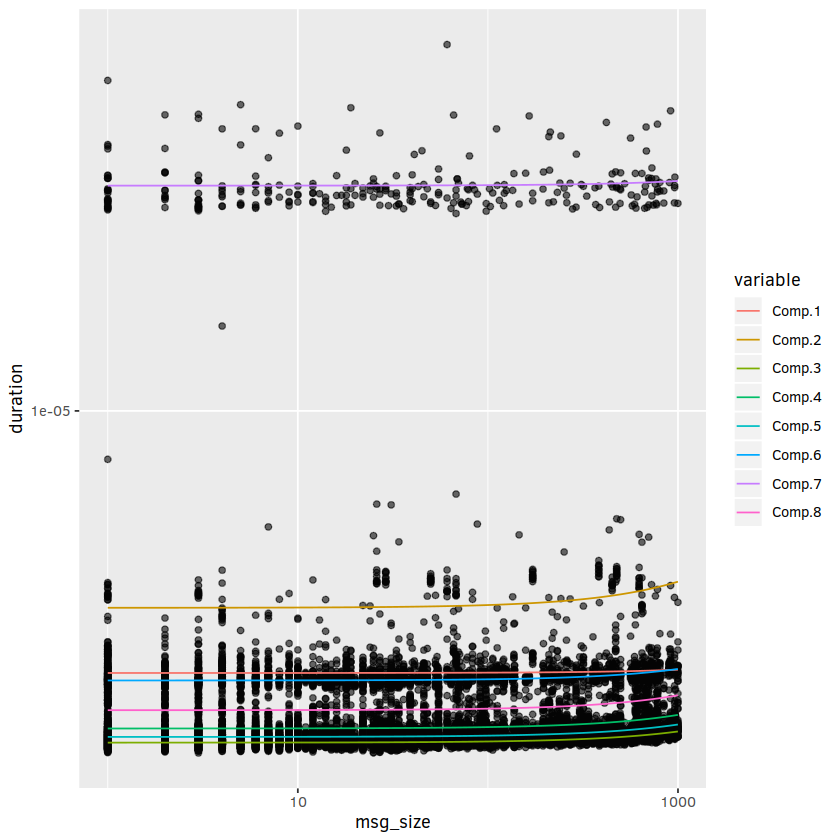

In [15]:
prediction = cbind(df[c('msg_size', 'duration')], fitted(m1))
prediction = melt(prediction, id=c('msg_size', 'duration'))
ggplot(prediction, aes(x=msg_size, y=duration)) + geom_point(alpha=0.1) + geom_line(aes(x=msg_size, y=value, color=variable)) + scale_x_log10() + scale_y_log10()